## Optimizing Personalized Treatment Strategies for Acute Hypotensive Patients

Description of Environment:

1. State Space: The state space represents the current condition of the patient which includes:
    * Vital signs: Heart rate, systolic and diastolic blood pressure, respiratory rate, oxygen saturation, etc.
    * Biochemical markers: Blood pH, lactate levels, creatinine, and other lab results that provide insights into organ function
    * Demographics and medical history: Patient age, gender, weight, comorbidities (e.g. diabetes, renal failure)
    * Previous treatment: Prior medication dosages and fluid levels administered during the current ICU stay. 

2. Action Space: Discrete treatment actions that a clinician could take to manage acute hypotension in ICU patients. This may include: 
    * Fluid Administration (e.g. low, medium, high dosage)
    * Vasopressor administration (e.g. low, medium, high dosage)
    * No intervention (wait and observe)
    Each of these actions will have an immediate impact on the patient’s state (e.g. vital signs, biochemical markers), making it crucial to optimize the sequence of actions based on the patient’s evolving condition. 

3. Reward Function: The reward at time step $t$ is dependent on the Mean Arterial Pressure $MAP_t$ and is given by:

$$\text{reward}_t = \begin{cases}
0 & \text{if MAP$_t > 65$} \\
\frac{-0.05(65-\text{MAP}_t)}{5} & \text{if $60 < \text{MAP}_t \le 65$} \\
\frac{-0.1(60-\text{MAP}_t)}{5}-0.05 & \text{if $55 < \text{MAP}_t \le 60$} \\
\frac{-0.85(55-\text{MAP}_t)}{15}-0.15 & \text{if $\text{MAP}_t \le 55$} \\
\end{cases}$$

But the reward value is also dictated, and overwritten by the urine output at time step t:

$$\text{reward}_t = 0 \text{ if urine}_t >30\text{ and MAP}_t >55$$

The objective of the project is to develop an AI-based decision support system that assists clinicians in personalizing treatment strategies for acute hypotension. We will :

* Learn to recommend optimal treatments based on patient-specific data, adapting in real-time to their evolving condition.
* Compare the performance of model-free approaches with model-based techniques to identify which provides more reliable and clinically relevant reccomendations
* Use off-policy evaluation methods such as weighted importance sampling and bootstrapping to ensure safe and effective policies without real-world deployment. 


---

### 0. Split Train Test

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
# load data
df = df = pd.read_csv('../data/C001_FakeHypotension.csv')
print(f'Number of unique patients: {df["PatientID"].nunique()}')
num_patients = df['PatientID'].nunique()

# rename columns
df.rename(columns={"PatientID": "id", "Timepoints": "hour"}, inplace=True)

Number of unique patients: 3910


In [4]:
# reward function
def reward_function(row):
    if row.MAP > 65: # 0 at >65
        reward = 0
    elif row.MAP > 60: # -0.05 at 60 and 0 at 65
        reward = -0.05 * (65 - row.MAP) / 5
    elif row.MAP > 55: # -0.15 at 55 and -0.05 at 60
        reward = -0.10 * (60 - row.MAP) / 5 - 0.05
    else: # -1 at 40 and -0.15 at 55
        reward = -0.85 * (55 - row.MAP) / 15 - 0.15
    if row.urine > 30 and row.MAP > 55:
        reward = 0
    return reward

# add the reward to the data
df['reward'] = df.apply(lambda row: reward_function(row), axis=1)
# shift one up so that reward is in the same row of action
df['reward'] = df['reward'].shift(-1)

In [5]:
# encode action to action number
fluid_boluses_dict = {
    **dict.fromkeys([0, 1, 2, 3], '[0, 250)'),
    **dict.fromkeys([4, 5, 6, 7], '[250, 500)'),
    **dict.fromkeys([8, 9, 10, 11], '[500, 1000)'),
    **dict.fromkeys([12, 13, 14, 15], '>= 1000')
}
vasopressors_dict = {
    **dict.fromkeys([0, 4, 8, 12], '0'),
    **dict.fromkeys([1, 5, 9, 13], '(0, 8.4)'),
    **dict.fromkeys([2, 6, 10, 14], '[8.4, 20.28)'),
    **dict.fromkeys([3, 7, 11, 15], '>= 20.28')
}

fluid_boluses_mapping = {v:i for i,v in enumerate(sorted(df['fluid_boluses'].unique()))}
vasopressors_mapping = {v:i for i,v in enumerate(sorted(df['vasopressors'].unique()))}
df['fluid_boluses'] = df['fluid_boluses'].map(fluid_boluses_mapping)
df['vasopressors'] = df['vasopressors'].map(vasopressors_mapping)
df['action_number'] = 4 * df['fluid_boluses'] + df['vasopressors']

In [6]:
# split train test
seed = 42
np.random.seed(seed)

train_ratio = 0.8
num_train_samples = int(num_patients * train_ratio)
train_ids = np.random.choice(num_patients, num_train_samples)
print(f'Number of patients in train data: {len(train_ids)}')

train_df = df[df["id"].isin(train_ids)].reset_index(drop=True)
test_df = df[~df["id"].isin(train_ids)].reset_index(drop=True)

print(f'Train Data: {train_df.shape}')
print(f'Test Data: {test_df.shape}')

Number of patients in train data: 3128
Train Data: (101376, 25)
Test Data: (86304, 25)


### 1. Tabular Q-Learning (Following HealthGym's tutorial)

Prepare data:

In [7]:
from sklearn.cluster import KMeans
from sklearn.cross_decomposition import PLSCanonical

In [8]:
# columns for states and actions
actions = ["fluid_boluses", "vasopressors"]
states = ["MAP", "diastolic_bp", "systolic_bp", "urine", "ALT", "AST", "PO2", "lactic_acid", "serum_creatinine", "FiO2", 
          "GCS_total", "urine_m", "ALT_AST_m", "FiO2_m", "GCS_total_m", "PO2_m", "lactic_acid_m", "serum_creatinine_m"]

In [9]:
# cross decomposition to reduce dimensionality
train_df_state = train_df[states]
train_df_action = train_df[actions]
train_df_action = pd.get_dummies(train_df_action, prefix=["fluid_boluses", "vasopressors"], columns=["fluid_boluses", "vasopressors"])

# partial least squares regression
plsca = PLSCanonical(n_components=5)

X = train_df_state.astype(float).values
Y = train_df_action.astype(float).values
X_norm = (X - X.mean(axis=0)) / (X.std(axis=0))
Y_norm = (Y - Y.mean(axis=0)) / (Y.std(axis=0))
X_canonical, Y_canonical = plsca.fit_transform(X_norm, Y_norm)

In [10]:
# k-means clustering to assign each patient to 1 cluster
num_states = 100
kmeans = KMeans(n_clusters=num_states, n_init=10, random_state=123)

state_numbers = kmeans.fit(X_canonical).labels_

We add the following variables:
* `hour`: time point between 0 and 47
* `action_number`: number between 0 and 15 indicating the action taken
* `state_number`: cluster asociated with the state at time t
* `state_number_tp1`: cluster associated with the state at time t+1

In [11]:
# add state number
X_train = train_df.copy()

X_train['state_number'] = state_numbers
X_train['state_number_tp1'] = X_train['state_number'].shift(-1)

X_train.head()

,Unnamed: 0,MAP,diastolic_bp,systolic_bp,urine,ALT,AST,PO2,lactic_acid,serum_creatinine,...,GCS_total_m,PO2_m,lactic_acid_m,serum_creatinine_m,id,hour,reward,action_number,state_number,state_number_tp1
0,48,39.952660,29.214905,108.805710,425.59628,19.907928,41.239155,99.31541,1.202458,0.925502,...,0,0,0,1,1,0,0.000000,8,24,49.0
1,49,68.468155,54.808110,101.934395,141.29442,28.589739,37.192097,95.09573,1.980157,1.350632,...,1,0,0,0,1,1,0.000000,1,49,24.0
2,50,57.901825,49.352460,98.348130,168.83945,21.603394,32.510864,116.30304,1.705058,1.007780,...,0,0,0,1,1,2,0.000000,1,24,75.0
3,51,64.464700,49.554610,104.063640,152.57677,29.738842,36.389750,115.09922,1.942347,1.357720,...,0,0,0,0,1,3,0.000000,1,75,19.0
4,52,77.893555,66.831276,115.173450,126.08959,27.832410,35.918148,98.64675,1.797520,1.080140,...,0,0,0,0,1,4,-1.100548,1,19,34.0


In [12]:
# ignore last hour since we don't observe reward of the last state
X_train = X_train[X_train["hour"] < 47]
X_train["state_number_tp1"] = X_train["state_number_tp1"].astype(int)

A simple algorithm for offline reinforcement learning (where we are given a fixed batch of data and can’t interact with the environment to collect new data) is Batch-Constrained Q-learning (BCQL). It determines an optimal policy in a way similar to standard Q-learning, except that the max over action values in the next state is taken only over actions that have actually been observed in the data.

In [13]:
# q-learning
Q = np.full((100, 16), np.nan, dtype='float') # 100 states, 16 actions

# Set to 0 if state-action combination has actually been observed in the data
for index, row in X_train.iterrows():
    state_number = int(row['state_number'])
    action_number = int(row['action_number'])
    Q[state_number, action_number] = 0

# parameters
num_iterations = 300
step_size = 0.1
gamma = 0.99
diff_tracker = np.zeros((num_iterations, 1))

# q-learning loop
for Q_iter in range(num_iterations):
    Q_old = Q.copy()
    for index, row in X_train.iterrows():
        state_number = int(row['state_number'])
        action_number = int(row['action_number'])
        state_number_tp1 = int(row['state_number_tp1'])
        Q[state_number, action_number] += step_size * (row['reward'] + gamma * np.nanmax(Q[state_number_tp1, :]) - Q[state_number, action_number])
    diff_tracker[Q_iter] = np.nanmean(np.abs(Q-Q_old))

    if (Q_iter > 0) and (Q_iter % 10 == 0):
        print(f"[Step {Q_iter}] Difference in Q-values: {diff_tracker[Q_iter][0]}")

[Step 10] Difference in Q-values: 0.0008632408002870604
[Step 20] Difference in Q-values: 0.00023965148263900245
[Step 30] Difference in Q-values: 7.853201287151403e-05
[Step 40] Difference in Q-values: 2.6852447632753353e-05
[Step 50] Difference in Q-values: 9.306193066916596e-06
[Step 60] Difference in Q-values: 3.239913197981494e-06
[Step 70] Difference in Q-values: 1.129728718751889e-06
[Step 80] Difference in Q-values: 3.941400201655222e-07
[Step 90] Difference in Q-values: 1.375335463348281e-07
[Step 100] Difference in Q-values: 4.799488981545824e-08
[Step 110] Difference in Q-values: 1.674908105095084e-08
[Step 120] Difference in Q-values: 5.845075310725627e-09
[Step 130] Difference in Q-values: 2.039811901279939e-09
[Step 140] Difference in Q-values: 7.118528491012444e-10
[Step 150] Difference in Q-values: 2.484220585316309e-10
[Step 160] Difference in Q-values: 8.669415435985847e-11
[Step 170] Difference in Q-values: 3.0254442232468724e-11
[Step 180] Difference in Q-values: 1.

**Evaluation**

The expected value of the RL policy can now be compared to the value of the original clinical policy or a random policy. The expected value of the RL policy is higher than for the other policies.

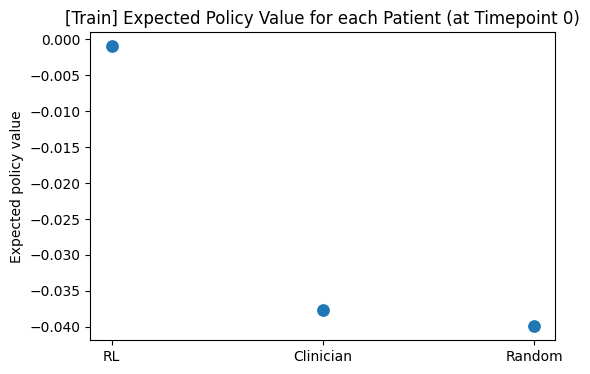

In [15]:
# evaluation on training data
Q_RL = 0
Q_random = 0
Q_clinician = 0

for index, row in X_train.iterrows():
    if row["hour"] == 0:
        # rl policy
        Q_RL += np.nanmax(Q[int(row['state_number']), :])

        # clinician policy
        Q_clinician += Q[int(row['state_number']), int(row['action_number'])]
        
        # random policy
        h = Q[int(row['state_number']), :]
        h = h[~np.isnan(h)]
        Q_random += h[np.random.choice(h.shape[0], 1)][0]

Q_RL = Q_RL / num_patients
Q_clinician = Q_clinician / num_patients
Q_random = Q_random / num_patients

plt.figure(figsize=(6, 4))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], markers='s', s=100)
plt.ylabel('Expected policy value')
plt.title('[Train] Expected Policy Value for each Patient (at Timepoint 0)')
plt.show()

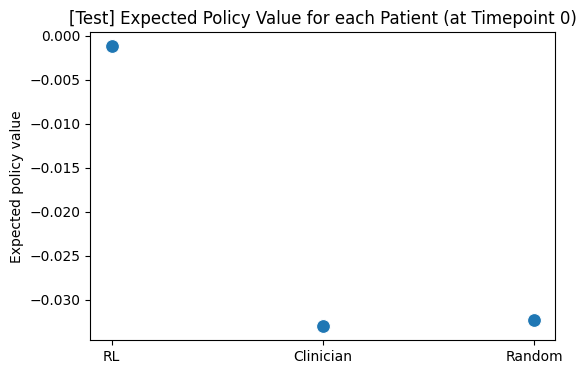

In [16]:
# normalize the test data
test_df_state = test_df[states]
X_test_state = test_df_state.astype(float).values
X_test_norm = (X_test_state - X.mean(axis=0)) / X.std(axis=0)

# apply PLSCanonical to test data
X_test_canonical = plsca.transform(X_test_norm)

# apply k-means to get state numbers
test_state_numbers = kmeans.predict(X_test_canonical)

# add state numbers to test data
X_test = test_df.copy()
X_test["state_number"] = test_state_numbers

# evaluation on test data
Q_RL = 0
Q_random = 0
Q_clinician = 0

for index, row in X_test.iterrows():
    if row["hour"] == 0:
        # rl policy
        Q_RL += np.nanmax(Q[int(row['state_number']), :])

        # clinician policy
        Q_clinician += Q[int(row['state_number']), int(row['action_number'])]
        
        # random policy
        h = Q[int(row['state_number']), :]
        h = h[~np.isnan(h)]
        Q_random += h[np.random.choice(h.shape[0], 1)][0]

Q_RL = Q_RL / num_patients
Q_clinician = Q_clinician / num_patients
Q_random = Q_random / num_patients

plt.figure(figsize=(6, 4))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], markers='s', s=100)
plt.ylabel('Expected policy value')
plt.title('[Test] Expected Policy Value for each Patient (at Timepoint 0)')
plt.show()

/var/folders/dd/zy6rfq2x43z3j43d1_ddscth0000gp/T/ipykernel_18140/1642850234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot_RF['action_number'] = 0
/var/folders/dd/zy6rfq2x43z3j43d1_ddscth0000gp/T/ipykernel_18140/1642850234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot_RF['agent'] = 'RF'
/var/folders/dd/zy6rfq2x43z3j43d1_ddscth0000gp/T/ipykernel_18140/1642850234.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

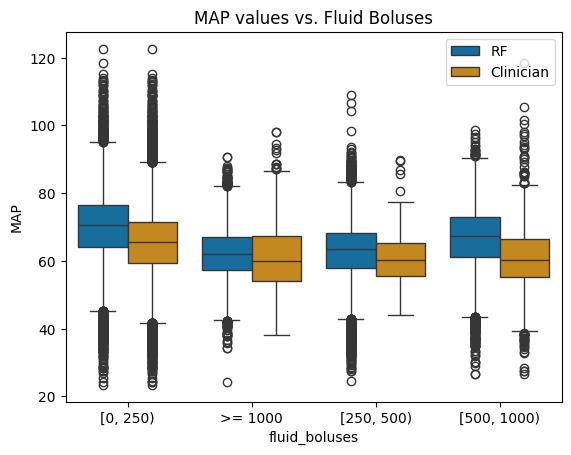

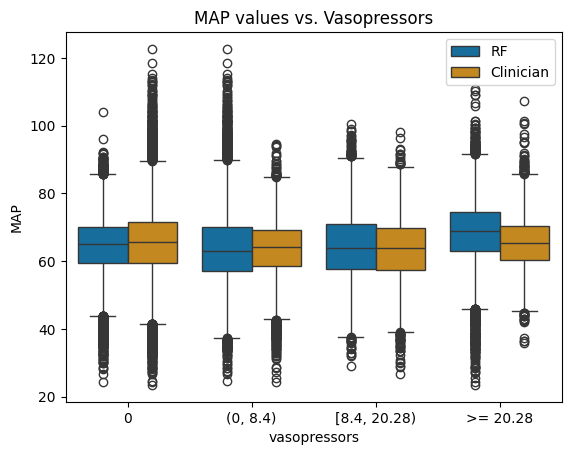

In [17]:
# MAP values for each action taken (test data)
df_boxplot_RF = X_test[['MAP']]
df_boxplot_RF['action_number'] = 0
for index, row in X_test.iterrows():
    df_boxplot_RF.at[index, 'action_number'] = np.nanargmax(Q[int(row['state_number']), :])

df_boxplot_RF['agent'] = 'RF'
df_boxplot_clinician = X_test[['MAP', 'action_number']]
df_boxplot_clinician['agent'] = 'Clinician'
df_boxplot = pd.concat([df_boxplot_RF, df_boxplot_clinician], ignore_index=True, sort=False)

df_boxplot['fluid_boluses'] = df_boxplot['action_number'].replace(fluid_boluses_dict)
df_boxplot['vasopressors'] = df_boxplot['action_number'].replace(vasopressors_dict)

sns.boxplot(y='MAP', x='fluid_boluses', data=df_boxplot, palette="colorblind", hue='agent')
plt.legend(loc="upper right")
plt.title("MAP values vs. Fluid Boluses")
plt.show()

sns.boxplot(y='MAP', x='vasopressors', data=df_boxplot, palette="colorblind", hue='agent', order=['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28'])
plt.legend(loc="upper right")
plt.title("MAP values vs. Vasopressors")
plt.show()

---

### 2. Discrete Batch Constrained Deep Q-Learning



In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque

Preprocess data - scale the state columns:

In [19]:
# transform the train and test data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(train_df[states]), columns=states)
X_test_scaled = pd.DataFrame(scaler.transform(test_df[states]), columns=states)

# add the necessary columns back
cols = ["id", "hour", "reward", "action_number"]
for col in cols:
    X_scaled[col] = train_df[col]
    X_test_scaled[col] = test_df[col]

Create a replay buffer and store all transitions:

In [20]:
# replay buffer method
class ReplayBuffer:
    def __init__(self, max_size=1000000, batch_size=32):
        self.buffer = deque(maxlen=max_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self):
        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        # convert to tensors
        return (
            torch.FloatTensor(states),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(next_states),
            torch.FloatTensor(dones)
        )

    def __len__(self):
        return len(self.buffer)

In [21]:
# store the transitions in the training data into the replay buffer
replay_buffer = ReplayBuffer()

for idx, row in X_scaled.iterrows():
    # terminal state, we don't observe reward, ignore
    if row["hour"] == 47: 
        continue
    else:
        id = row["id"]
        hour = row["hour"]

        state = np.array(row[states].values)
        action = int(row["action_number"])
        reward = row["reward"]

        next_state_row = X_scaled[(X_scaled["id"]==id) & (X_scaled["hour"]==hour+1)]
        next_state = np.array(next_state_row[states].values[0])
        done = 0

        replay_buffer.add(state, action, reward, next_state, done)

Set up the offline RL agent:

In [22]:
# get the theoretical bounds of the q-values (we clamp the q-values for better convergence)
gamma = 0.99
v_min = X_scaled['reward'].min() / (1 - gamma)
v_max = X_scaled['reward'].max() / (1 - gamma)
print(f'Theoretical bounds of q-values: [{v_min}, {v_max}]')

Theoretical bounds of q-values: [-216.77837199999976, 0.0]


In [23]:
# behavior cloning model - outputs a distribution over the 16 discrete actions
class BehaviorCloning(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128, v_min=v_min, v_max=v_max):
        super(BehaviorCloning, self).__init__()
        self.v_min= v_min
        self.v_max = v_max
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        
        # weight initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.uniform_(self.fc3.weight, -1e-2, 1e-2)  # Small weights for output layer
        nn.init.uniform_(self.fc3.bias, -1e-2, 1e-2)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.clamp(x, min=self.v_min, max=self.v_max)
    
class Q_Network(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128, v_min=v_min, v_max=v_max):
        super(Q_Network, self).__init__()
        self.v_min= v_min
        self.v_max = v_max
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        
        # weight initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.uniform_(self.fc3.weight, -1e-2, 1e-2)  # Small weights for output layer
        nn.init.uniform_(self.fc3.bias, -1e-2, 1e-2)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.clamp(x, min=self.v_min, max=self.v_max)
    

# BCQ for discrete actions
class DiscreteBCQ:
    def __init__(self, state_dim, action_dim, hidden_dim=128, gamma=0.99, bcq_threshold=0.3, target_update_steps=5000, device="mps"):
        self.gamma = gamma
        self.threshold = bcq_threshold
        self.target_update_steps = target_update_steps
        self.device = device

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_network = Q_Network(state_dim, action_dim, hidden_dim).to(device)
        self.target_q_network = Q_Network(state_dim, action_dim, hidden_dim).to(device)
        self.behavior_model = BehaviorCloning(state_dim, action_dim, hidden_dim).to(device)

        self.q_optimizer = optim.Adam(self.q_network.parameters(), lr=1e-5)
        self.behavior_optimizer = optim.Adam(self.behavior_model.parameters(), lr=1e-5)

        # copy weights to target model
        self.target_q_network.load_state_dict(self.q_network.state_dict())

        # losses
        self.q_losses = []
        self.behavior_losses = []
        self.losses = []

    def select_action(self, states):
        # select action according to policy
        with torch.no_grad():
            # get q values from q-network (using current q_network as in Double DQN)
            q_values = self.q_network(states)

            # calculate action probabilities from behavior model
            behavior_logits = self.behavior_model(states)
            log_action_probs = F.log_softmax(behavior_logits, dim=1)

            # Normalize the log probabilities by subtracting the maximum log probability
            ratio = log_action_probs - log_action_probs.max(dim=1, keepdim=True).values
            # create a mask 
            mask = (ratio > np.log(self.threshold)).float()

            # normalize the q-values by subtracting the min Q-values across actions
            normalized_q_values = q_values - q_values.min(dim=1, keepdim=True).values

            # Apply the mask: zero out Q-values for invalid actions
            masked_q_values = normalized_q_values * mask

            # Select the action with the highest masked Q-value
            next_actions = masked_q_values.argmax(dim=1)
            
            return next_actions
    
    def save_model(self, filepath):
        """Save the Q-network and Target-network to the specified filepath."""
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_q_network.state_dict(),
            'behavior_network': self.behavior_model.state_dict(),
            'optimizer': self.q_optimizer.state_dict(),
            'behavior_optimizer': self.behavior_optimizer.state_dict()
        }, filepath)

    def load_model(self, filepath):
        """Load the Q-network and Target-network from the specified filepath."""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_q_network.load_state_dict(checkpoint['target_network'])
        self.behavior_model.load_state_dict(checkpoint['behavior_network'])
        if 'optimizer' in checkpoint:
            self.q_optimizer.load_state_dict(checkpoint['optimizer'])
            self.behavior_optimizer.load_state_dict(checkpoint['behavior_optimizer'])
              
    def train(self, replay_buffer, num_steps):
        for iteration in range(num_steps):
            # sample from replay buffer
            states, actions, rewards, next_states, dones = replay_buffer.sample()
            states, actions, rewards, next_states, dones = states.to(self.device), actions.to(self.device), rewards.to(self.device), next_states.to(self.device), dones.to(self.device)

            # behavior cloning (cross-entropy loss with one-hot actions)
            behavior_logits = self.behavior_model(states)
            log_probs = F.log_softmax(behavior_logits, dim=1)
            penalty = (behavior_logits ** 2).mean()
            behavior_loss = F.nll_loss(log_probs, actions) + 0.5 * penalty

            # update behavior model
            self.behavior_optimizer.zero_grad()
            behavior_loss.backward()
            self.behavior_optimizer.step()

            # select next action using behavior model
            next_actions = self.select_action(next_states)

            # compute q-targets
            with torch.no_grad():
                q_values_next = self.target_q_network(next_states)
                q_values_next = q_values_next.gather(1, next_actions.unsqueeze(1)).squeeze(1)
                q_targets = rewards + (self.gamma * (1 - dones) * q_values_next)

            # compute current q estimates
            q_current = self.q_network(states)
            q_current = q_current.gather(1, actions.unsqueeze(1)).squeeze(1)

            # q loss
            q_loss = F.smooth_l1_loss(q_current, q_targets) 

            # update q-network
            self.q_optimizer.zero_grad()
            q_loss.backward()
            self.q_optimizer.step()

            # hard update for target q
            if (iteration > 0) and (iteration % self.target_update_steps == 0):
                self.target_q_network.load_state_dict(self.q_network.state_dict())

            # store loss
            self.q_losses.append(q_loss.item())
            self.behavior_losses.append(behavior_loss.item())
            self.losses.append(q_loss.item() + behavior_loss.item())

            if (iteration > 0) and (iteration % 5000 == 0):
                avg_q_loss = sum(self.q_losses[-5000:]) / 5000
                avg_b_loss = sum(self.behavior_losses[-5000:]) / 5000
                total_avg_loss = sum(self.losses[-5000:]) / 5000
                print(f'[Step {iteration}/{num_steps}] Loss: {total_avg_loss:.8f}\tAvg Q-Loss: {avg_q_loss:.8f}\tAvg Imitator Loss: {avg_b_loss:.8f}')

In [28]:
# train the agent
discrete_bcq_agent = DiscreteBCQ(state_dim=18, action_dim=16, hidden_dim=128)
discrete_bcq_agent.train(replay_buffer, num_steps=200000)

RuntimeError: PyTorch is not linked with support for mps devices

In [31]:
# save agent
torch.save(discrete_bcq_agent, "DiscreteBCQ/bcq_agent.pth")
discrete_bcq_agent.save_model(filepath="DiscreteBCQ/models.pth")

**Evaluation**

In [ ]:
# evaluation on training
Q_RL = 0
Q_random = 0
Q_clinician = 0

# set model to evaluation
discrete_bcq_agent.q_network.eval()

for idx, row in X_scaled.iterrows():
    if row["hour"] == 0:
        state = np.array(row[states].values)
        state = torch.FloatTensor(state).unsqueeze(0).to(discrete_bcq_agent.device)
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to(discrete_bcq_agent.device)

        with torch.no_grad():
            q_values = discrete_bcq_agent.q_network(state)
            max_q_value = torch.max(q_values).item()
            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()
            random_q_value = np.random.choice(q_values[0].cpu())

            Q_RL += max_q_value
            Q_random += random_q_value
            Q_clinician += clinician_q_value

# normalize by number of patient
Q_RL /= num_patients
Q_clinician /= num_patients
Q_random /= num_patients

# Visualization
plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.8)
plt.ylabel('Expected policy value')
plt.title('[Train] Expected Policy Value for each Patient (Timepoint = 0)')
plt.show()

In [ ]:
# evaluate for test
Q_RL = 0
Q_random = 0
Q_clinician = 0

# set model to evaluation
discrete_bcq_agent.q_network.eval()

for idx, row in X_test_scaled.iterrows():
    if row["hour"] == 0:
        state = np.array(row[states].values)
        state = torch.FloatTensor(state).unsqueeze(0).to(discrete_bcq_agent.device)
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to(discrete_bcq_agent.device)

        with torch.no_grad():
            q_values = discrete_bcq_agent.q_network(state)
            max_q_value = torch.max(q_values).item()
            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()
            random_q_value = np.random.choice(q_values[0].cpu())

            Q_RL += max_q_value
            Q_random += random_q_value
            Q_clinician += clinician_q_value

# normalize by number of patient
Q_RL /= num_patients
Q_clinician /= num_patients
Q_random /= num_patients

# Visualization
plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.8)
plt.ylabel('Expected policy value')
plt.title('[Test] Expected Policy Value for each Patient (Timepoint = 0)')
plt.show()

In [ ]:
# MAP values for each action taken (test data)
df_boxplot_RF = X_test_scaled[['MAP']]
df_boxplot_RF['action_number'] = 0

for index, row in X_test_scaled.iterrows():
    state = np.array(row[states].values)
    state = torch.FloatTensor(state).unsqueeze(0).to(discrete_bcq_agent.device)
    action = int(row["action_number"])
    action = torch.LongTensor([action]).to(discrete_bcq_agent.device)

    with torch.no_grad():
        q_values = discrete_bcq_agent.q_network(state)
        rl_action = torch.argmax(q_values).item()

    df_boxplot_RF.at[index, 'action_number'] = rl_action

df_boxplot_RF['agent'] = 'RF'
df_boxplot_clinician = X_test_scaled[['MAP', 'action_number']]
df_boxplot_clinician['agent'] = 'Clinician'
df_boxplot = pd.concat([df_boxplot_RF, df_boxplot_clinician], ignore_index=True, sort=False)

df_boxplot['fluid_boluses'] = df_boxplot['action_number'].replace(fluid_boluses_dict)
df_boxplot['vasopressors'] = df_boxplot['action_number'].replace(vasopressors_dict)

sns.boxplot(y='MAP', x='fluid_boluses', data=df_boxplot, palette="colorblind", hue='agent')
plt.legend(loc="upper right")
plt.title("MAP values vs. Fluid Boluses")
plt.show()

sns.boxplot(y='MAP', x='vasopressors', data=df_boxplot, palette="colorblind", hue='agent', order=['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28'])
plt.legend(loc="upper right")
plt.title("MAP values vs. Vasopressors")
plt.show()

---

### 3. Conservative Q-Learning

Base Model: DoubleDQN

In [14]:
class DiscreteCQL:
    def __init__(self, state_dim, action_dim, hidden_dim=128, gamma=0.99, alpha=0.5, target_update_freq=1000, device="mps"):
        self.gamma = gamma
        self.alpha = alpha
        self.device = device
        self.target_update_freq = target_update_freq

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_network = Q_Network(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network = Q_Network(state_dim, action_dim, hidden_dim).to(self.device)

        # copy weights to target model
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=1e-5)

        # losses
        self.td_losses = []
        self.conservative_losses = []
        self.cql_losses = []

    def compute_loss(self, states, actions, rewards, next_states, dones):
        # 1. calculate bellman error (td error)
        # compute q-values for current states
        q_values = self.q_network(states)
        curr_q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        # compute next q-values using target network using action selected by current q_network (DDQN framework to reduce overestimation)
        with torch.no_grad():
            next_q_values_q_network = self.q_network(next_states)
            next_actions = next_q_values_q_network.argmax(dim=1)
            next_q_values_target = self.target_network(next_states)
            next_q_values = next_q_values_target.gather(1, next_actions.unsqueeze(1)).squeeze(1)
        
        # compute td error
        td_target = rewards + (self.gamma * next_q_values * (1 - dones))
        td_error = F.mse_loss(curr_q_values, td_target)

        # 2. conservative loss: penalize over-estimation of OOD actions
        logsumexp_q_values = torch.logsumexp(q_values, dim=1)
        conservative_loss = (logsumexp_q_values - curr_q_values).mean()

        # 3. total loss
        cql_loss = td_error + self.alpha * conservative_loss
        return cql_loss, td_error, conservative_loss
    
    def train(self, replay_buffer, num_steps):
        for iteration in range(num_steps):
            # sample from replay buffer
            states, actions, rewards, next_states, dones = replay_buffer.sample()
            states, actions, rewards, next_states, dones = states.to(self.device), actions.to(self.device), rewards.to(self.device), next_states.to(self.device), dones.to(self.device)

            # compute loss
            cql_loss, td_loss, conservative_loss = self.compute_loss(states, actions, rewards, next_states, dones)

            # optimize
            self.optimizer.zero_grad()
            cql_loss.backward()
            self.optimizer.step()

            # update target network
            if (iteration > 0) and (iteration % self.target_update_freq == 0):
                self.target_network.load_state_dict(self.q_network.state_dict())

            # store and log loss
            self.cql_losses.append(cql_loss.item())
            self.td_losses.append(td_loss.item())
            self.conservative_losses.append(conservative_loss.item())

            if (iteration > 0) and (iteration % 5000 == 0):
                avg_td_loss = sum(self.td_losses[-5000:]) / 5000
                avg_cons_loss = sum(self.conservative_losses[-5000:]) / 5000
                avg_total_loss = sum(self.cql_losses[-5000:]) / 5000
                print(f'[Step {iteration}/{num_steps}] Total Loss: {avg_total_loss:.7f}\tTD Loss: {avg_td_loss:.7f}\tConservative Loss: {avg_cons_loss:.7f}')

    def save_model(self, filepath):
        """Save the Q-network and Target-network to the specified filepath."""
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict()  # Optional: to save optimizer state too
        }, filepath)

    def load_model(self, filepath):
        """Load the Q-network and Target-network from the specified filepath."""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        if 'optimizer' in checkpoint:
            self.optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
# train discrete cql agent
discrete_cql_agent = DiscreteCQL(state_dim=18, action_dim=16)
discrete_cql_agent.train(replay_buffer, num_steps=400000)

In [ ]:
# since the loss is still decreasing, continue to run
discrete_cql_agent.train(replay_buffer, num_steps=200000)

In [ ]:
# since the loss is still decreasing, continue to run
discrete_cql_agent.train(replay_buffer, num_steps=400000)

In [53]:
# save model
torch.save(discrete_cql_agent, "DiscreteCQL/cql_agent.pth")
discrete_cql_agent.save_model(filepath="DiscreteCQL/model.pth")

Evaluation:

In [ ]:
# evaluation on training
Q_RL = 0
Q_random = 0
Q_clinician = 0

# set model to evaluation
discrete_cql_agent.q_network.eval()

for idx, row in X_scaled.iterrows():
    if row["hour"] == 0:
        state = np.array(row[states].values)
        state = torch.FloatTensor(state).unsqueeze(0).to(discrete_cql_agent.device)
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to(discrete_cql_agent.device)

        with torch.no_grad():
            q_values = discrete_cql_agent.q_network(state)
            max_q_value = torch.max(q_values).item()
            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()
            random_q_value = np.random.choice(q_values[0].cpu())

            Q_RL += max_q_value
            Q_random += random_q_value
            Q_clinician += clinician_q_value

# normalize by number of patient
Q_RL /= num_patients
Q_clinician /= num_patients
Q_random /= num_patients

# Visualization
plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.8)
plt.ylabel('Expected policy value')
plt.title('[Train] Expected Policy Value for each Patient (Timepoint = 0)')
plt.show()

In [ ]:
# evaluate for test
Q_RL = 0
Q_random = 0
Q_clinician = 0

# set model to evaluation
discrete_cql_agent.q_network.eval()

for idx, row in X_test_scaled.iterrows():
    if row["hour"] == 0:
        state = np.array(row[states].values)
        state = torch.FloatTensor(state).unsqueeze(0).to(discrete_cql_agent.device)
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to(discrete_cql_agent.device)

        with torch.no_grad():
            q_values = discrete_cql_agent.q_network(state)
            max_q_value = torch.max(q_values).item()
            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()
            random_q_value = np.random.choice(q_values[0].cpu())

            Q_RL += max_q_value
            Q_random += random_q_value
            Q_clinician += clinician_q_value

# normalize by number of patient
Q_RL /= num_patients
Q_clinician /= num_patients
Q_random /= num_patients

# Visualization
plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.8)
plt.ylabel('Expected policy value')
plt.title('[Test] Expected Policy Value for each Patient (Timepoint = 0)')
plt.show()

In [ ]:
# MAP values for each action taken (test data)
df_boxplot_RF = X_test_scaled[['MAP']]
df_boxplot_RF['action_number'] = 0

for index, row in X_test_scaled.iterrows():
    state = np.array(row[states].values)
    state = torch.FloatTensor(state).unsqueeze(0).to(discrete_cql_agent.device)
    action = int(row["action_number"])
    action = torch.LongTensor([action]).to(discrete_cql_agent.device)

    with torch.no_grad():
        q_values = discrete_cql_agent.q_network(state)
        rl_action = torch.argmax(q_values).item()

    df_boxplot_RF.at[index, 'action_number'] = rl_action

df_boxplot_RF['agent'] = 'RF'
df_boxplot_clinician = X_test_scaled[['MAP', 'action_number']]
df_boxplot_clinician['agent'] = 'Clinician'
df_boxplot = pd.concat([df_boxplot_RF, df_boxplot_clinician], ignore_index=True, sort=False)

df_boxplot['fluid_boluses'] = df_boxplot['action_number'].replace(fluid_boluses_dict)
df_boxplot['vasopressors'] = df_boxplot['action_number'].replace(vasopressors_dict)

sns.boxplot(y='MAP', x='fluid_boluses', data=df_boxplot, palette="colorblind", hue='agent')
plt.legend(loc="upper right")
plt.title("MAP values vs. Fluid Boluses")
plt.show()

sns.boxplot(y='MAP', x='vasopressors', data=df_boxplot, palette="colorblind", hue='agent', order=['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28'])
plt.legend(loc="upper right")
plt.title("MAP values vs. Vasopressors")
plt.show()

---

### 4. Distributional DQN

We incorporate the Conservative Q-Learning (CQL) principle into the Distributional DQN to help address the out-of-distribution action issue. The CQL loss is computed as the difference between the logsumexp of Q-values (which tends to overestimate) and the Q-value of the taken action. By minimizing this difference, we encourage the learned Q-function to be more conservative, especially for out-of-distribution actions.

In [45]:
class DistributionalDQN(nn.Module):
    def __init__(self, state_dim, action_dim, num_atoms, v_min, v_max):
        super(DistributionalDQN, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_atoms = num_atoms
        self.v_min = v_min
        self.v_max = v_max

        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim * num_atoms)
        )

        self.register_buffer("supports", torch.linspace(v_min, v_max, num_atoms))

    def forward(self, state):
        dist = self.network(state).view(-1, self.action_dim, self.num_atoms)
        return torch.softmax(dist, dim=-1)

class DistributionalDQNAgent:
    def __init__(self, state_dim, action_dim, num_atoms=51, v_min=-10, v_max=10, learning_rate=1e-3, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, target_update=10, cql_alpha=0.5):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_atoms = num_atoms
        self.v_min = v_min
        self.v_max = v_max
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.target_update = target_update
        self.cql_alpha = cql_alpha  # CQL regularization parameter

        self.policy_net = DistributionalDQN(state_dim, action_dim, num_atoms, v_min, v_max)
        self.target_net = DistributionalDQN(state_dim, action_dim, num_atoms, v_min, v_max)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.steps_done = 0

    def select_action(self, state):
        if random.random() > self.epsilon:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0)
                dist = self.policy_net(state)
                expected_value = (dist * self.policy_net.supports).sum(2)
                return expected_value.max(1)[1].item()
        else:
            return random.randrange(self.action_dim)

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def train(self, replay_buffer, num_steps):
        for iteration in range(num_steps):
            if len(replay_buffer) < replay_buffer.batch_size:
                continue
            
            # Sample from replay buffer
            states, actions, rewards, next_states, dones = replay_buffer.sample()
            batch_size = states.shape[0]  # Get the actual batch size from the sampled data
            
            # Compute current Q distributions
            current_q_dist = self.policy_net(states)
            current_q_dist_for_taken_actions = current_q_dist[range(batch_size), actions]

            # Compute next Q distributions
            with torch.no_grad():
                next_q_dist = self.target_net(next_states)
                next_actions = (next_q_dist * self.target_net.supports).sum(2).max(1)[1]
                next_q_dist = next_q_dist[range(batch_size), next_actions]

            # Compute projected distribution (Bellman update)
            delta_z = (self.v_max - self.v_min) / (self.num_atoms - 1)
            tz = rewards.unsqueeze(1) + self.gamma * (1 - dones).unsqueeze(1) * self.target_net.supports.unsqueeze(0)
            tz = tz.clamp(self.v_min, self.v_max)
            b = (tz - self.v_min) / delta_z
            l = b.floor().long()
            u = b.ceil().long()

            projected_dist = torch.zeros_like(next_q_dist)
            projected_dist.scatter_add_(1, l, next_q_dist * (u.float() - b))
            projected_dist.scatter_add_(1, u, next_q_dist * (b - l.float()))

            # Compute Distributional DQN loss
            dqn_loss = -(projected_dist * torch.log(current_q_dist_for_taken_actions + 1e-8)).sum(1).mean()

            # Compute CQL loss
            q_values = (current_q_dist * self.policy_net.supports).sum(2)
            cql_loss = torch.logsumexp(q_values, dim=1).mean() - q_values.gather(1, actions.unsqueeze(1)).mean()

            # Total loss
            loss = dqn_loss + self.cql_alpha * cql_loss

            # Optimize
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 100)
            self.optimizer.step()

            # Update target network
            if (iteration > 0) and (iteration % self.target_update == 0):
                self.target_net.load_state_dict(self.policy_net.state_dict())

            # Log losses
            if hasattr(self, 'losses'):
                self.losses.append(loss.item())
                self.dqn_losses.append(dqn_loss.item())
                self.cql_losses.append(cql_loss.item())
            else:
                self.losses = [loss.item()]
                self.dqn_losses = [dqn_loss.item()]
                self.cql_losses = [cql_loss.item()]

            if (iteration > 0) and (iteration % 5000 == 0):
                avg_loss = sum(self.losses[-5000:]) / 5000
                avg_dqn_loss = sum(self.dqn_losses[-5000:]) / 5000
                avg_cql_loss = sum(self.cql_losses[-5000:]) / 5000
                print(f'[Step {iteration}/{num_steps}] Avg Loss: {avg_loss:.7f}, DQN Loss: {avg_dqn_loss:.7f}, CQL Loss: {avg_cql_loss:.7f}')

        self.update_epsilon()

    def save_model(self, filepath):
        torch.save(self.policy_net.state_dict(), filepath)

    def load_model(self, filepath):
        self.policy_net.load_state_dict(torch.load(filepath))
        self.target_net.load_state_dict(self.policy_net.state_dict())

In [46]:
# train distributional dqn agent
distributional_dqn_agent = DistributionalDQNAgent(state_dim=18, action_dim=16, num_atoms=51, v_min=v_min, v_max=v_max, cql_alpha=0.5)
distributional_dqn_agent.train(replay_buffer, num_steps=400000)


[Step 5000/400000] Avg Loss: 4.1596149, DQN Loss: 3.8771544, CQL Loss: 0.5649209
[Step 10000/400000] Avg Loss: 4.1079109, DQN Loss: 3.8609893, CQL Loss: 0.4938432
[Step 15000/400000] Avg Loss: 4.0568651, DQN Loss: 3.8228170, CQL Loss: 0.4680962
[Step 20000/400000] Avg Loss: 3.9797917, DQN Loss: 3.7535469, CQL Loss: 0.4524896
[Step 25000/400000] Avg Loss: 3.8654005, DQN Loss: 3.6486268, CQL Loss: 0.4335473
[Step 30000/400000] Avg Loss: 3.7532080, DQN Loss: 3.5408083, CQL Loss: 0.4247993
[Step 35000/400000] Avg Loss: 3.6268582, DQN Loss: 3.4197793, CQL Loss: 0.4141578
[Step 40000/400000] Avg Loss: 3.4959477, DQN Loss: 3.2920969, CQL Loss: 0.4077016
[Step 45000/400000] Avg Loss: 3.3674707, DQN Loss: 3.1672156, CQL Loss: 0.4005102
[Step 50000/400000] Avg Loss: 3.2161376, DQN Loss: 3.0178096, CQL Loss: 0.3966560
[Step 55000/400000] Avg Loss: 3.0577189, DQN Loss: 2.8617536, CQL Loss: 0.3919306
[Step 60000/400000] Avg Loss: 2.8317821, DQN Loss: 2.6418054, CQL Loss: 0.3799534
[Step 65000/40000

In [47]:
# since the loss is still decreasing, continue to run
distributional_dqn_agent.train(replay_buffer, num_steps=200000)


[Step 5000/200000] Avg Loss: 0.7837908, DQN Loss: 0.5731800, CQL Loss: 0.4212216
[Step 10000/200000] Avg Loss: 0.7950282, DQN Loss: 0.5819943, CQL Loss: 0.4260678
[Step 15000/200000] Avg Loss: 0.7815688, DQN Loss: 0.5724330, CQL Loss: 0.4182716
[Step 20000/200000] Avg Loss: 0.7880012, DQN Loss: 0.5774772, CQL Loss: 0.4210480
[Step 25000/200000] Avg Loss: 0.7813242, DQN Loss: 0.5708943, CQL Loss: 0.4208599
[Step 30000/200000] Avg Loss: 0.7722606, DQN Loss: 0.5593225, CQL Loss: 0.4258762
[Step 35000/200000] Avg Loss: 0.7686041, DQN Loss: 0.5593659, CQL Loss: 0.4184764
[Step 40000/200000] Avg Loss: 0.7846070, DQN Loss: 0.5733048, CQL Loss: 0.4226044
[Step 45000/200000] Avg Loss: 0.7836086, DQN Loss: 0.5699949, CQL Loss: 0.4272274
[Step 50000/200000] Avg Loss: 0.7876196, DQN Loss: 0.5709226, CQL Loss: 0.4333941
[Step 55000/200000] Avg Loss: 0.7871428, DQN Loss: 0.5682550, CQL Loss: 0.4377755
[Step 60000/200000] Avg Loss: 0.7823634, DQN Loss: 0.5661565, CQL Loss: 0.4324138
[Step 65000/20000

In [49]:
# save model
# torch.save(distributional_dqn_agent, "../models/DistributionalDQN/distributional_dqn_agent.pth")
# distributional_dqn_agent.save_model(filepath="../models/DistributionalDQN/model.pth")

Evaluation:

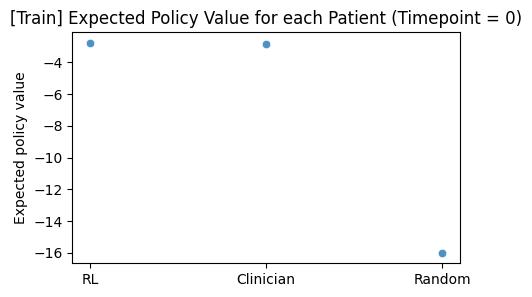

In [50]:
# evaluation on training
Q_RL = 0
Q_random = 0
Q_clinician = 0

# set model to evaluation
distributional_dqn_agent.policy_net.eval()

for idx, row in X_scaled.iterrows():
    if row["hour"] == 0:
        state = np.array(row[states].values)
        state = torch.FloatTensor(state).unsqueeze(0).to(distributional_dqn_agent.policy_net.supports.device)
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to(distributional_dqn_agent.policy_net.supports.device)

        with torch.no_grad():
            dist = distributional_dqn_agent.policy_net(state)
            q_values = (dist * distributional_dqn_agent.policy_net.supports).sum(2)
            max_q_value = torch.max(q_values).item()
            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()
            random_q_value = np.random.choice(q_values[0].cpu())

            Q_RL += max_q_value
            Q_random += random_q_value
            Q_clinician += clinician_q_value

# normalize by number of patient
Q_RL /= num_patients
Q_clinician /= num_patients
Q_random /= num_patients

# Visualization
plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.8)
plt.ylabel('Expected policy value')
plt.title('[Train] Expected Policy Value for each Patient (Timepoint = 0)')
plt.show()

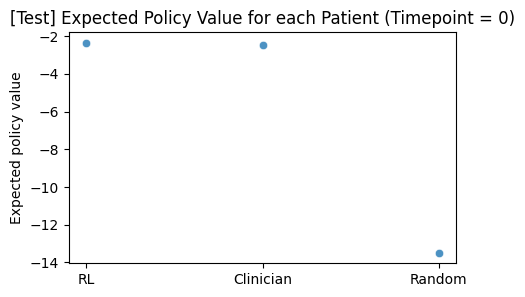

In [51]:
# evaluate for test
Q_RL = 0
Q_random = 0
Q_clinician = 0

# set model to evaluation
distributional_dqn_agent.policy_net.eval()

for idx, row in X_test_scaled.iterrows():
    if row["hour"] == 0:
        state = np.array(row[states].values)
        state = torch.FloatTensor(state).unsqueeze(0).to(distributional_dqn_agent.policy_net.supports.device)
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to(distributional_dqn_agent.policy_net.supports.device)

        with torch.no_grad():
            dist = distributional_dqn_agent.policy_net(state)
            q_values = (dist * distributional_dqn_agent.policy_net.supports).sum(2)
            max_q_value = torch.max(q_values).item()
            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()
            random_q_value = np.random.choice(q_values[0].cpu())

            Q_RL += max_q_value
            Q_random += random_q_value
            Q_clinician += clinician_q_value

# normalize by number of patient
Q_RL /= num_patients
Q_clinician /= num_patients
Q_random /= num_patients

# Visualization
plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.8)
plt.ylabel('Expected policy value')
plt.title('[Test] Expected Policy Value for each Patient (Timepoint = 0)')
plt.show()

In [52]:
# MAP values for each action taken (test data)
df_boxplot_RF = X_test_scaled[['MAP']]
df_boxplot_RF['action_number'] = 0

for index, row in X_test_scaled.iterrows():
    state = np.array(row[states].values)
    state = torch.FloatTensor(state).unsqueeze(0).to(distributional_dqn_agent.policy_net.supports.device)
    action = int(row["action_number"])
    action = torch.LongTensor([action]).to(distributional_dqn_agent.policy_net.supports.device)

    with torch.no_grad():
        dist = distributional_dqn_agent.policy_net(state)
        q_values = (dist * distributional_dqn_agent.policy_net.supports).sum(2)
        rl_action = torch.argmax(q_values).item()

    df_boxplot_RF.at[index, 'action_number'] = rl_action

df_boxplot_RF['agent'] = 'RF'
df_boxplot_clinician = X_test_scaled[['MAP', 'action_number']]
df_boxplot_clinician['agent'] = 'Clinician'
df_boxplot = pd.concat([df_boxplot_RF, df_boxplot_clinician], ignore_index=True, sort=False)

df_boxplot['fluid_boluses'] = df_boxplot['action_number'].replace(fluid_boluses_dict)
df_boxplot['vasopressors'] = df_boxplot['action_number'].replace(vasopressors_dict)

sns.boxplot(y='MAP', x='fluid_boluses', data=df_boxplot, palette="colorblind", hue='agent')
plt.legend(loc="upper right")
plt.title("MAP values vs. Fluid Boluses")
plt.show()

sns.boxplot(y='MAP', x='vasopressors', data=df_boxplot, palette="colorblind", hue='agent', order=['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28'])
plt.legend(loc="upper right")
plt.title("MAP values vs. Vasopressors")
plt.show()

/var/folders/dd/zy6rfq2x43z3j43d1_ddscth0000gp/T/ipykernel_18140/33646012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot_RF['action_number'] = 0


___

### Evaluation

Load the models:

In [ ]:
# Discrete BCQ
discrete_bcq_agent = DiscreteBCQ(state_dim=18, action_dim=16)
discrete_bcq_agent.load_model("../models/DiscreteBCQ/models.pth")

# Discrete CQL
discrete_cql_agent = DiscreteCQL(state_dim=18, action_dim=16)
discrete_cql_agent.load_model("../models/DiscreteCQL/models.pth")

# Distributional DQN
distributional_dqn_agent = DistributionalDQNAgent(state_dim=18, action_dim=16)
distributional_dqn_agent.load_model("../models/DistributionalDQN/model.pth")


Evaluation metrics:

1. Off-Policy Evaluation: Estimate the performance of a policy without interacting with the environment. 

    * **Weighted Importance Sampling**: Calculate the expected reward using a weighted sum of observed rewards, with the weights based on how likely the actions taken by the clinician are under the learned policy. Good performance on WIS suggests that the policy performs well in regions of the state-action space where the clinician policy overlaps with your learned policy.

2. **Policy Value Estimation**: Estimate the expected return (cumulative rewards) of each policy using offline data. Since you have trained on historical data, this gives an idea of how well the policies would perform if deployed. If one model consistently has a higher estimated policy value, it indicates that it may provide better clinical outcomes.

3. **Action Alignment with Clinician**: Comparing the actions taken by each model with those taken by clinicians gives insight into how much the models diverge from clinical practice. A high alignment suggests the model is conservative and safe, while divergence might indicate novel, potentially riskier strategies.

4. **Statistical Testing**: Use statistical tests to assess if differences between the clinician policy and learned policies are significant. For example, a paired t-test or Mann-Whitney U test could be used to compare the rewards associated with each policy. If the learned policies significantly outperform or match the clinician policy, they may represent viable alternatives for decision-making.

5. **Out-of-Distribution (OOD) Performance**: Given that BCQ and CQL are designed to handle OOD states, evaluating their robustness in unseen situations is crucial. This could involve identifying specific patient groups or states that were underrepresented in the training data and checking performance. Robust policies that maintain good performance in OOD states are more suitable for deployment in real-world scenarios with varied patient populations.

6. **Explainability and Action Diversity**: Since CQL penalizes overestimation and BCQ is designed to mimic human actions, you can check how much each policy explores and diverges from typical clinician decisions. Plot the action distribution to visualize where the policies align with or diverge from clinician behavior. If a model explores too much, it may risk patient safety, while low exploration might indicate conservativeness.



---

**1. Weighted Importance Sampling**

For WIS, we need to train a clinician policy to estimate the clinician's action probabilities. This is necessary because we often do not have access to the true clinician action distribution.

Then, we reweight the offline data to simulate how the learned policy would have performed, even though the data was collected using the clinician’s policy. This is crucial for policy evaluation in offline settings where we cannot interact with the environment. Using weighted importance sampling helps reduce the variance of standard importance sampling, which can be high if the evaluation policy differs significantly from the clinician policy. It gives you a more stable estimate of the policy’s value.

In [60]:
# behavior cloning model - outputs a distribution over the 16 discrete actions
class Q_Network(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128, v_min=v_min, v_max=v_max):
        super(Q_Network, self).__init__()
        self.v_min= v_min
        self.v_max = v_max
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        
        # weight initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.uniform_(self.fc3.weight, -1e-2, 1e-2)  # Small weights for output layer
        nn.init.uniform_(self.fc3.bias, -1e-2, 1e-2)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.clamp(x, min=self.v_min, max=self.v_max)
    

# BCQ for discrete actions
class ClinicianAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=128, gamma=0.99, device="mps"):
        self.gamma = gamma
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
        self.device = device
        self.network = Q_Network(state_dim, action_dim, hidden_dim).to(self.device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=1e-4)
        self.losses = []
    
    def save_model(self, filepath):
        """Save the network to the specified filepath."""
        torch.save({
            'network': self.network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
        }, filepath)

    def load_model(self, filepath):
        """Load the network from the specified filepath."""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.network.load_state_dict(checkpoint['network'])
        if 'optimizer' in checkpoint:
            self.optimizer.load_state_dict(checkpoint['optimizer'])
              
    def train(self, replay_buffer, num_steps):
        for iteration in range(num_steps):
            # sample from replay buffer
            states, actions, rewards, next_states, dones = replay_buffer.sample()
            states, actions, rewards, next_states, dones = states.to(self.device), actions.to(self.device), rewards.to(self.device), next_states.to(self.device), dones.to(self.device)

            # behavior cloning (cross-entropy loss with one-hot actions)
            logits = self.network(states)
            log_probs = F.log_softmax(logits, dim=1)
            loss = F.nll_loss(log_probs, actions)

            # update behavior model
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # store loss
            self.losses.append(loss.item())

            if (iteration > 0) and (iteration % 5000 == 0):
                avg_loss = sum(self.losses[-5000:]) / 5000
                print(f'[Step {iteration}/{num_steps}] Loss: {avg_loss:.8f}')

In [ ]:
# train clinician policy
clinician_agent = ClinicianAgent(state_dim=18, action_dim=16, hidden_dim=128)
clinician_agent.train(replay_buffer, num_steps=150000)

In [ ]:
clinician_agent.train(replay_buffer, num_steps=200000)

Save the clinician policy:

In [66]:
# save model
torch.save(clinician_agent, "Clinician/agent.pth")
clinician_agent.save_model(filepath="Clinician/model.pth")

Weighted Importance Sampling:

In [117]:
state_columns = ["MAP", "diastolic_bp", "systolic_bp", "urine", "ALT", "AST", "PO2", "lactic_acid", "serum_creatinine", "FiO2", 
                 "GCS_total", "urine_m", "ALT_AST_m", "FiO2_m", "GCS_total_m", "PO2_m", "lactic_acid_m", "serum_creatinine_m"]

def get_policy_probs(network, states):
    with torch.no_grad():
        q_values = network(states)
        probs = F.softmax(q_values, dim=1).cpu().numpy()
    return probs

def weighted_importance_sampling(policy_network, clinician_network, state, action, reward):
    """Compute weighted importance sampling for policy evaluation"""
    # get probabilities of the actions that were actually taken
    policy_probs = get_policy_probs(policy_network, state.unsqueeze(0))
    policy_action_probs = policy_probs[0, action]
    
    clinician_probs = get_policy_probs(clinician_network, state.unsqueeze(0))
    clinician_action_probs = clinician_probs[0, actions]

    # compute importance weights
    importance_weights = policy_action_probs / clinician_action_probs

    # weighted sum of rewards
    weighted_rewards = importance_weights * reward
    return weighted_rewards

def compute_wis_for_trajectory(df, clinician_policy, learned_policy, gamma=0.99):
    clinician_rewards = []
    policy_rewards = []

    unique_patients = list(df["id"].unique())
    for id in unique_patients:
        patient_clinician_reward = 0
        patient_policy_reward = 0

        # get the rows for the patient
        patient_df = df[df["id"]==id].reset_index(drop=True)
        
        for i, row in patient_df.iterrows():
            hour = row["hour"]

            # ignore last hour (since reward for last timepoint is captured by 46)
            if hour == 47:
                continue
            reward = row["reward"]
            action = torch.tensor(row["action_number"]).long()
            state = torch.tensor(row[state_columns].values).float().to('mps')
            wis_estimate = weighted_importance_sampling(learned_policy, clinician_policy, state, action, reward)
            #print(reward, wis_estimate)

            patient_clinician_reward += (gamma ** hour) * reward
            patient_policy_reward += (gamma ** hour) * wis_estimate
        
        clinician_rewards.append(patient_clinician_reward)
        policy_rewards.append(patient_policy_reward)
    
    avg_clinician_rewards = sum(clinician_rewards) / len(clinician_rewards)
    avg_policy_rewards = sum(policy_rewards) / len(policy_rewards)
    return avg_clinician_rewards, avg_policy_rewards, clinician_rewards, policy_rewards


In [ ]:
# get expected cumulative rewards
avg_clinician_rewards, avg_bcq_rewards, clinician_rewards, bcq_rewards = compute_wis_for_trajectory(X_test_scaled, clinician_agent.network, discrete_bcq_agent.q_network)
_, avg_cql_rewards, _, cql_rewards = compute_wis_for_trajectory(X_test_scaled, clinician_agent.network, discrete_cql_agent.q_network)

print(f'Expected cumulative reward for Clinician Policy: {avg_clinician_rewards}')
print(f'Expected cumulative reward for Discrete BCQ Policy: {avg_bcq_rewards}')
print(f'Expected cumulative reward for Discrete CQL Policy: {avg_cql_rewards}')

In [ ]:
from scipy.stats import ttest_rel

# Conduct a paired t-test to compare rewards of learned policies and clinician actions
_, p_value_bcq = ttest_rel(bcq_rewards, clinician_rewards)
_, p_value_cql = ttest_rel(cql_rewards, clinician_rewards)

# Interpret the p-value: 
if p_value_bcq < 0.05:
    print("BCQ policy significantly differs from clinician policy")
else:
    print("BCQ policy does not significantly differ from clinician policy")

if p_value_cql < 0.05:
    print("CQL policy significantly differs from clinician policy")
else:
    print("CQL policy does not significantly differ from clinician policy")

**2. Action Alignment with Clinician Actions**

In [120]:
def get_policy_actions(policy_network, states):
    """Get the actions predicted by the policy"""
    with torch.no_grad():
        q_values =policy_network(states)

    policy_actions = torch.argmax(q_values, dim=1)
    return policy_actions

def action_alignment(policy_network, states, actions):
    policy_actions = get_policy_actions(policy_network, states)
    alignment = (policy_actions == actions).sum().item() / len(actions)
    return alignment * 100

In [ ]:
# check alignment
states = torch.tensor(X_test_scaled[state_columns].values).float().to("mps")
actions = torch.tensor(X_test_scaled["action_number"].values).long().to("mps")
bcq_alignment = action_alignment(discrete_bcq_agent.q_network, states, actions)
cql_alignment = action_alignment(discrete_cql_agent.q_network, states, actions)

print(f"Actions Matched for Discrete BCQ Policy: {bcq_alignment}")
print(f"Actions Matched for Discrete CQL Policy: {cql_alignment}")

In [136]:
# Function to decode actions to fluid boluses and vasopressors
def decode_action(action):
    fluid = fluid_boluses_dict[action]
    vasopressor = vasopressors_dict[action]
    return fluid, vasopressor

def get_clinician_action_distribution(clinician_actions):
    """Compute the decoded action distribution for clinician actions."""
    # Initialize count matrix
    fluid_categories = ['[0, 250)', '[250, 500)', '[500, 1000)', '>= 1000']  # Sorted fluid boluses
    vasopressor_categories = ['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28']  # Sorted vasopressors
    action_count_matrix = np.zeros((len(vasopressor_categories), len(fluid_categories)))

    # Count the occurrences of each fluid-vasopressor combination
    for action in clinician_actions:
        fluid, vasopressor = decode_action(action)  # Use the same decode_action function
        fluid_idx = fluid_categories.index(fluid)
        vasopressor_idx = vasopressor_categories.index(vasopressor)
        action_count_matrix[vasopressor_idx, fluid_idx] += 1

    # Normalize to get a probability distribution
    action_distribution = action_count_matrix / len(clinician_actions)
    
    return action_distribution, fluid_categories, vasopressor_categories


def get_action_distribution(policy_network, states):
    """Compute the decoded action distribution for the given policy network."""
    with torch.no_grad():
        q_values = policy_network(states)
    
    predicted_actions = torch.argmax(q_values, dim=1).cpu().numpy()
    
    # Initialize count matrix
    fluid_categories = ['[0, 250)', '[250, 500)', '[500, 1000)', '>= 1000']  # Sorted fluid boluses
    vasopressor_categories = ['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28']  # Sorted vasopressors
    action_count_matrix = np.zeros((len(vasopressor_categories), len(fluid_categories)))

    # Count the occurrences of each fluid-vasopressor combination
    for action in predicted_actions:
        fluid, vasopressor = decode_action(action)
        fluid_idx = fluid_categories.index(fluid)
        vasopressor_idx = vasopressor_categories.index(vasopressor)
        action_count_matrix[vasopressor_idx, fluid_idx] += 1

    # Normalize to get a probability distribution
    action_distribution = action_count_matrix / len(predicted_actions)
    
    return action_distribution, fluid_categories, vasopressor_categories

In [ ]:
action_distribution_clinician, fluid_categories, vasopressor_categories = get_clinician_action_distribution(np.array(actions.cpu()))
action_distribution_bcq, fluid_categories, vasopressor_categories = get_action_distribution(discrete_bcq_agent.q_network, states)
action_distribution_cql, _, _ = get_action_distribution(discrete_cql_agent.q_network, states)

# Plot the action distribution 
plt.figure(figsize=(5, 4))
sns.heatmap(action_distribution_clinician, annot=True, cmap="Blues", xticklabels=fluid_categories, yticklabels=vasopressor_categories)
plt.title('Action Distribution for Clinician Actions')
plt.xlabel('Fluid Boluses', fontsize=11)
plt.ylabel('Vasopressors', fontsize=11)
plt.tick_params(labelsize=9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
sns.heatmap(action_distribution_bcq, annot=True, cmap="Blues", xticklabels=fluid_categories, yticklabels=vasopressor_categories)
plt.title('Action Distribution for BCQ Policy')
plt.xlabel('Fluid Boluses', fontsize=11)
plt.ylabel('Vasopressors', fontsize=11)
plt.tick_params(labelsize=9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
sns.heatmap(action_distribution_cql, annot=True, cmap="Blues", xticklabels=fluid_categories, yticklabels=vasopressor_categories)
plt.title('Action Distribution for CQL Policy')
plt.xlabel('Fluid Boluses', fontsize=11)
plt.ylabel('Vasopressors', fontsize=11)
plt.tick_params(labelsize=9)
plt.tight_layout()
plt.show()

**Distribution of Q-Values**

In [155]:
q_values_dist = pd.DataFrame(columns=["id", "hour", "clinician", "bcq"])
discrete_bcq_agent.q_network.eval()

for _, row in X_test_scaled.iterrows():
    if row["hour"] != 47:
        state = torch.FloatTensor(row[state_columns].values).unsqueeze(0).to("mps")
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to("mps")

        with torch.no_grad():
            q_values = discrete_bcq_agent.q_network(state)
            bcq_q_value = torch.max(q_values).item()

            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()

        q_values_dist.loc[len(q_values_dist)] = [row["id"], row["hour"], clinician_q_value, bcq_q_value]

In [ ]:
# plot 
plt.figure(figsize=(10, 4))
sns.lineplot(x="hour", y="clinician", data=q_values_dist, errorbar="sd")
sns.lineplot(x="hour", y="bcq", data=q_values_dist, errorbar="sd")
plt.title("Smoothed Q-Values over Timepoint", fontsize=12)
plt.xlabel("Timepoint", fontsize=10)
plt.ylabel("Q-Values", fontsize=10)
plt.tick_params(labelsize=8)
plt.ylim([-0.3, 0.04])
plt.legend(["Clinician", "Clinician SD", "BCQ"], loc="lower right")
plt.show()

In [160]:
q_values_dist = pd.DataFrame(columns=["id", "hour", "clinician", "cql"])
discrete_cql_agent.q_network.eval()

for _, row in X_test_scaled.iterrows():
    if row["hour"] != 47:
        state = torch.FloatTensor(row[state_columns].values).unsqueeze(0).to("mps")
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to("mps")

        with torch.no_grad():
            q_values = discrete_cql_agent.q_network(state)
            cql_q_value = torch.max(q_values).item()

            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()

        q_values_dist.loc[len(q_values_dist)] = [row["id"], row["hour"], clinician_q_value, cql_q_value]

In [ ]:
# plot 
plt.figure(figsize=(10, 4))
sns.lineplot(x="hour", y="clinician", data=q_values_dist, errorbar="sd")
sns.lineplot(x="hour", y="cql", data=q_values_dist, errorbar="sd")
plt.title("Smoothed Q-Values over Timepoint", fontsize=12)
plt.xlabel("Timepoint", fontsize=10)
plt.ylabel("Q-Values", fontsize=10)
plt.tick_params(labelsize=8)
plt.ylim([-2, 1.0])
plt.legend(["Clinician", "Clinician SD", "CQL", "CQL SD"], loc="lower right")
plt.show()

**3. Identify and Compare performance on OOD States**

In [182]:
import numpy as np
import scipy.spatial

def fit_mahalanobis(training_states):
    # Compute the mean and covariance of the training data
    mean_vector = np.mean(training_states, axis=0)
    cov_matrix = np.cov(training_states, rowvar=False)
    
    # Invert the covariance matrix for Mahalanobis calculation
    cov_matrix_inv = np.linalg.inv(cov_matrix)
    
    return mean_vector, cov_matrix_inv

def calculate_mahalanobis_distance(test_states, mean_vector, cov_matrix_inv):
    distances = []
    for state in test_states:
        diff = state - mean_vector
        distance = np.sqrt(np.dot(np.dot(diff.T, cov_matrix_inv), diff))
        distances.append(distance)
    return np.array(distances)

def identify_ood_states(test_states, training_states, threshold=None):
    # Fit Mahalanobis model
    mean_vector, cov_matrix_inv = fit_mahalanobis(training_states)
    
    # Calculate distances
    distances = calculate_mahalanobis_distance(test_states, mean_vector, cov_matrix_inv)
    
    # Determine threshold if not provided
    if threshold is None:
        # Set threshold as, for example, the 95th percentile of training distances
        train_distances = calculate_mahalanobis_distance(training_states, mean_vector, cov_matrix_inv)
        threshold = np.percentile(train_distances, 95)
    
    # Identify OOD states
    ood_indices = np.where(distances > threshold)[0]
    ood_states = test_states[ood_indices]
    
    return ood_states, ood_indices

In [172]:
# get the states for training and test
training_states = []
for _, row in X_scaled.iterrows():
    if row["hour"] == 47:
        continue
    state = np.array(row[state_columns].values)
    training_states.append(state)

test_states = []
for _, row in X_test_scaled.iterrows():
    if row["hour"] == 47:
        continue
    state = np.array(row[state_columns].values)
    test_states.append(state)

training_states = np.array(training_states)
test_states = np.array(test_states)

In [183]:
# get ood states
ood_states, ood_indices = identify_ood_states(test_states, training_states)

In [186]:
# get the data 
X_test_ood = pd.DataFrame(columns=X_test_scaled.columns)
for i, row in X_test_scaled.iterrows():
    if i in ood_indices:
        X_test_ood.loc[len(X_test_ood)] = row

In [ ]:
# check alignment
ood_states = torch.tensor(X_test_ood[state_columns].values).float().to("mps")
ood_actions = torch.tensor(X_test_ood["action_number"].values).long().to("mps")
bcq_alignment = action_alignment(discrete_bcq_agent.q_network, ood_states, ood_actions)
cql_alignment = action_alignment(discrete_cql_agent.q_network, ood_states, ood_actions)

print(f"Actions Matched for Discrete BCQ Policy: {bcq_alignment}")
print(f"Actions Matched for Discrete CQL Policy: {cql_alignment}")

In [ ]:
# compare performance
action_distribution_clinician, fluid_categories, vasopressor_categories = get_clinician_action_distribution(np.array(ood_actions.cpu()))
action_distribution_bcq, fluid_categories, vasopressor_categories = get_action_distribution(discrete_bcq_agent.q_network, ood_states)
action_distribution_cql, _, _ = get_action_distribution(discrete_cql_agent.q_network, ood_states)

# Plot the action distribution 
plt.figure(figsize=(5, 4))
sns.heatmap(action_distribution_clinician, annot=True, cmap="Blues", xticklabels=fluid_categories, yticklabels=vasopressor_categories)
plt.title('Action Distribution for Clinician Actions')
plt.xlabel('Fluid Boluses', fontsize=11)
plt.ylabel('Vasopressors', fontsize=11)
plt.tick_params(labelsize=9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
sns.heatmap(action_distribution_bcq, annot=True, cmap="Blues", xticklabels=fluid_categories, yticklabels=vasopressor_categories)
plt.title('Action Distribution for BCQ Policy')
plt.xlabel('Fluid Boluses', fontsize=11)
plt.ylabel('Vasopressors', fontsize=11)
plt.tick_params(labelsize=9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
sns.heatmap(action_distribution_cql, annot=True, cmap="Blues", xticklabels=fluid_categories, yticklabels=vasopressor_categories)
plt.title('Action Distribution for CQL Policy')
plt.xlabel('Fluid Boluses', fontsize=11)
plt.ylabel('Vasopressors', fontsize=11)
plt.tick_params(labelsize=9)
plt.tight_layout()
plt.show()

Compare q-values:

In [191]:
q_values_dist = pd.DataFrame(columns=["id", "hour", "clinician", "bcq"])
discrete_bcq_agent.q_network.eval()

for _, row in X_test_ood.iterrows():
    if row["hour"] != 47:
        state = torch.FloatTensor(row[state_columns].values).unsqueeze(0).to("mps")
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to("mps")

        with torch.no_grad():
            q_values = discrete_bcq_agent.q_network(state)
            bcq_q_value = torch.max(q_values).item()

            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()

        q_values_dist.loc[len(q_values_dist)] = [row["id"], row["hour"], clinician_q_value, bcq_q_value]

In [ ]:
# plot 
plt.figure(figsize=(10, 4))
sns.lineplot(x="hour", y="clinician", data=q_values_dist, errorbar="sd")
sns.lineplot(x="hour", y="bcq", data=q_values_dist, errorbar="sd")
plt.title("Smoothed Q-Values over Timepoint", fontsize=12)
plt.xlabel("Timepoint", fontsize=10)
plt.ylabel("Q-Values", fontsize=10)
plt.tick_params(labelsize=8)
plt.ylim([-0.2, 0.05])
plt.legend(["Clinician", "Clinician SD", "BCQ", "BCQ SD"], loc="lower right")
plt.show()

In [194]:
q_values_dist = pd.DataFrame(columns=["id", "hour", "clinician", "cql"])
discrete_cql_agent.q_network.eval()

for _, row in X_test_ood.iterrows():
    if row["hour"] != 47:
        state = torch.FloatTensor(row[state_columns].values).unsqueeze(0).to("mps")
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to("mps")

        with torch.no_grad():
            q_values = discrete_cql_agent.q_network(state)
            cql_q_value = torch.max(q_values).item()

            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()

        q_values_dist.loc[len(q_values_dist)] = [row["id"], row["hour"], clinician_q_value, cql_q_value]

In [ ]:
# plot 
plt.figure(figsize=(10, 4))
sns.lineplot(x="hour", y="clinician", data=q_values_dist, errorbar="sd")
sns.lineplot(x="hour", y="cql", data=q_values_dist, errorbar="sd")
plt.title("Smoothed Q-Values over Timepoint", fontsize=12)
plt.xlabel("Timepoint", fontsize=10)
plt.ylabel("Q-Values", fontsize=10)
plt.tick_params(labelsize=8)
plt.ylim([-3, 1.0])
plt.legend(["Clinician", "Clinician SD", "CQL", "CQL SD"], loc="lower right")
plt.show()

Compare the actions taken at different MAP values:

In [223]:
def categorize_map(row):
    if row.MAP > 65:
        return ">65"
    elif row.MAP > 60:
        return "60-65"
    elif row.MAP > 55:
        return "55-60"
    else:
        return "<55"

# Apply this to the dataset
test_df['MAP_tier'] = test_df.apply(categorize_map, axis=1)

In [225]:
# apply to scaled test
X_test_scaled['MAP_tier'] = np.array(test_df['MAP_tier'])

In [199]:
# get the predicted action 
def get_action(policy_network, states):
    """Compute the decoded action distribution for the given policy network."""
    with torch.no_grad():
        q_values = policy_network(states)
    
    predicted_actions = torch.argmax(q_values, dim=1).cpu().numpy()
    predicted_fluids = []
    predicted_vasopressors = []
    for action in predicted_actions:
        fluid, vasopressor = decode_action(action)
        predicted_fluids.append(fluid)
        predicted_vasopressors.append(vasopressor)
    
    return np.array(predicted_fluids), np.array(predicted_vasopressors)

In [230]:
# get the actions
bcq_fluids, bcq_vasopressors = get_action(discrete_bcq_agent.q_network, states)
cql_fluids, cql_vasopressors = get_action(discrete_cql_agent.q_network, states)

X_test_copy = X_test_scaled.copy()
X_test_copy["bcq_fluid"] = bcq_fluids
X_test_copy["bcq_vasopressor"] = bcq_vasopressors
X_test_copy["cql_fluid"] = cql_fluids
X_test_copy["cql_vasopressor"] = cql_vasopressors
X_test_copy['clinician_fluid'], X_test_copy['clinician_vasopressor'] = zip(*X_test_copy['action_number'].map(decode_action))

In [235]:
# group by MAP tier and action type
bcq_action_counts = X_test_copy.groupby(["MAP_tier", "bcq_fluid", "bcq_vasopressor"]).size().reset_index(name="bcq_count")
cql_action_counts = X_test_copy.groupby(["MAP_tier", "cql_fluid", "cql_vasopressor"]).size().reset_index(name="cql_count")
clinician_action_counts = X_test_copy.groupby(["MAP_tier", "clinician_fluid", "clinician_vasopressor"]).size().reset_index(name="clinician_count")

# Define ordered categories for MAP tiers and actions
map_tier_order = ["<55", "55-60", "60-65", ">65"]
fluid_bolus_order = ["[0, 250)", "[250, 500)", "[500, 1000)", ">= 1000"]
vasopressor_order = ["0", "(0, 8.4)", "[8.4, 20.28)", ">= 20.28"]

# Convert MAP_tier, policy_fluid, and policy_vasopressor columns to categorical with specific ordering
bcq_action_counts['MAP_tier'] = pd.Categorical(bcq_action_counts['MAP_tier'], categories=map_tier_order, ordered=True)
bcq_action_counts['bcq_fluid'] = pd.Categorical(bcq_action_counts['bcq_fluid'], categories=fluid_bolus_order, ordered=True)
bcq_action_counts['bcq_vasopressor'] = pd.Categorical(bcq_action_counts['bcq_vasopressor'], categories=vasopressor_order, ordered=True)

cql_action_counts['MAP_tier'] = pd.Categorical(cql_action_counts['MAP_tier'], categories=map_tier_order, ordered=True)
cql_action_counts['cql_fluid'] = pd.Categorical(cql_action_counts['cql_fluid'], categories=fluid_bolus_order, ordered=True)
cql_action_counts['cql_vasopressor'] = pd.Categorical(cql_action_counts['cql_vasopressor'], categories=vasopressor_order, ordered=True)

clinician_action_counts['MAP_tier'] = pd.Categorical(clinician_action_counts['MAP_tier'], categories=map_tier_order, ordered=True)
clinician_action_counts['clinician_fluid'] = pd.Categorical(clinician_action_counts['clinician_fluid'], categories=fluid_bolus_order, ordered=True)
clinician_action_counts['clinician_vasopressor'] = pd.Categorical(clinician_action_counts['clinician_vasopressor'], categories=vasopressor_order, ordered=True)

In [ ]:
# Plotting fluid bolus comparison
plt.figure(figsize=(6, 4))
sns.barplot(data=bcq_action_counts, x='MAP_tier', y='bcq_count', hue='bcq_fluid', palette="ch:s=.25,rot=-.25", err_kws={'linewidth': 1})
plt.title('Policy Fluid Boluses by MAP Tier')
plt.ylabel('Count of Actions')
plt.tick_params(labelsize=8)
plt.show()

# Plotting vasopressor comparison
plt.figure(figsize=(6, 4))
sns.barplot(data=bcq_action_counts, x='MAP_tier', y='bcq_count', hue='bcq_vasopressor', palette="ch:s=.25,rot=-.25", err_kws={'linewidth': 1})
plt.title('Policy Vasopressors by MAP Tier')
plt.ylabel('Count of Actions')
plt.tick_params(labelsize=8)
plt.show()

In [ ]:
# Plotting fluid bolus comparison
plt.figure(figsize=(6, 4))
sns.barplot(data=clinician_action_counts, x='MAP_tier', y='clinician_count', hue='clinician_fluid', palette="ch:s=.25,rot=-.25", err_kws={'linewidth': 1})
plt.title('Clinician Fluid Boluses by MAP Tier')
plt.ylabel('Count of Actions')
plt.tick_params(labelsize=8)
plt.show()

# Plotting vasopressor comparison
plt.figure(figsize=(6, 4))
sns.barplot(data=clinician_action_counts, x='MAP_tier', y='clinician_count', hue='clinician_vasopressor', palette="ch:s=.25,rot=-.25", err_kws={'linewidth': 1})
plt.title('Clinician Vasopressors by MAP Tier')
plt.ylabel('Count of Actions')
plt.tick_params(labelsize=8)
plt.show()